# Capstone: Predicting Car Collision Outcomes Based on Situational Classification Data

## PART I of II

### Project Description

Between 2014 and 2018, the City of Ottawa in Canada saw a total of 72,834 collisions on municipal roads with an average of 14,567 collisions per year over the same timeframe.

Using Open Data datasets for the City of Ottawa and Canadian Ministry of Transportation data, determine locations of collision hotspots and other data such as street lighting locations, construction zones, times of heavy traffic, weather conditions that could pretict locations and situations of higher collision risk. 

Ottawa was selected as a city of interest for this project due to the availability of detailed data.
Open Data (Ottawa): https://open.ottawa.ca/datasets/2019-tabular-transportation-collision-data
Ministry of Transportation: https://tc.canada.ca/en/canadian-motor-vehicle-traffic-collision-statistics-2018##fnr


Predicting Traffic Accident Hotspots
https://carto.com/blog/predicting-traffic-accident-hotspots-with-spatial-data-science/

### Data Clean & Starter Visualizations

### Step One: Import, Inspect, and Clean Data
- Explore features, look at distributions, and determine how to handle any missing values.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# Read the CSV file form 
collision = pd.read_csv('./data/2019_Tabular_Transportation_Collision_Data.csv')
collision.head(1)

,Anom_ID,Accident_Date,Accident_Time,Location,Geo_ID,Accident_Location,Classification_Of_Accident,Initial_Impact_Type,Environment_Condition,Light,Road_Surface_Condition,Traffic_Control,Traffic_Control_Condition,X,Y,LONGITUDE,LATITUDE,ObjectId
0,19-Jan,2019/01/01 00:00:00+00,2021/01/15 03:00:00+00,AIRPORT PKWY btwn AIRPORT PKWY & RAMP (1) (__3...,__3ZA22Y,01 - Non intersection,03 - P.D. only,07 - SMV other,03 - Snow,07 - Dark,04 - Slush,10 - No control,NaN,371081.4809,5023385.252,-75.654154,45.347281,1


#### Check for Non-Null Values

In [183]:
collision.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16399 entries, 0 to 16398
Data columns (total 18 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   Anom_ID                     16399 non-null  object 
 1   Accident_Date               16399 non-null  object 
 2   Accident_Time               16399 non-null  object 
 3   Location                    16399 non-null  object 
 4   Geo_ID                      16399 non-null  object 
 5   Accident_Location           16399 non-null  object 
 6   Classification_Of_Accident  16399 non-null  object 
 7   Initial_Impact_Type         16399 non-null  object 
 8   Environment_Condition       16399 non-null  object 
 9   Light                       16399 non-null  object 
 10  Road_Surface_Condition      16399 non-null  object 
 11  Traffic_Control             16399 non-null  object 
 12  Traffic_Control_Condition   8736 non-null   object 
 13  X                           163

In [184]:
# Just over half of data is missing form Traffic_Control_Condition
compare_traffic_control = collision[['Traffic_Control','Traffic_Control_Condition']]
compare_traffic_control.head(5)

,Traffic_Control,Traffic_Control_Condition
0,10 - No control,NaN
1,01 - Traffic signal,00 - Unknown
2,01 - Traffic signal,01 - Functioning
3,10 - No control,NaN
4,10 - No control,NaN


In [185]:
# Check if number of "10 - No control" items in Traffic_Control equals the number of NaNs in Traffic_Control_Condition
# 1 - "10 - No control"
# 0 - other
n = compare_traffic_control['Traffic_Control'].str.count('10 - No control')
n

0        1
1        0
2        0
3        1
4        1
        ..
16394    1
16395    1
16396    1
16397    1
16398    1
Name: Traffic_Control, Length: 16399, dtype: int64

In [186]:
# Count 1s (10 - No control) and 0s (NaN)
n.value_counts()

0    8732
1    7667
Name: Traffic_Control, dtype: int64

In [187]:
# 7667 "10 - No control" items in Traffic_Control
# 7663 NaNs in Traffic_Control_Condition
16399 - 8736

7663

In [188]:
# Check where the 4 lines of "10 - No control" != NaN
compare_traffic_control.loc[(compare_traffic_control['Traffic_Control'] == '10 - No control') & (compare_traffic_control['Traffic_Control_Condition'].notna())]

,Traffic_Control,Traffic_Control_Condition
1887,10 - No control,00 - Unknown
2643,10 - No control,00 - Unknown
3462,10 - No control,00 - Unknown
13313,10 - No control,00 - Unknown


Traffic_Control_Conditions is a label that indicates if the traffic control, such as a Traffic Signal, Stop sign etc. is 01 - Functioning, 02 - Not Functioning, 03 - Obscured, 04 - Missing, 00 - Unknown or Nan which is assumed to also indicate Unknown.

Out of the 7663 indices that contain '10 - No control' in Traffic_Control column, the corresponding index under 'Traffic_Control_Condition' is NaN. The remaining four indices are "00 - Unknown". "Traffic_Control_Condition" column is the only column in the collision data frame containing NaN values.

Because all NaN values are connected with '10 - No Control', it is assumed that a condition didn't need to be met, so NaN values can be updated to '05 - None' to remove NaN from the collision data frame. For consistency, the four '00 - Unknown' conditions can also be changed to '05 - None'.

In [189]:
collision['Traffic_Control_Condition'] = collision['Traffic_Control_Condition'].replace(np.nan,'05 - None')
collision.head(2) # NaN is replaced by '05 - None'

,Anom_ID,Accident_Date,Accident_Time,Location,Geo_ID,Accident_Location,Classification_Of_Accident,Initial_Impact_Type,Environment_Condition,Light,Road_Surface_Condition,Traffic_Control,Traffic_Control_Condition,X,Y,LONGITUDE,LATITUDE,ObjectId
0,19-Jan,2019/01/01 00:00:00+00,2021/01/15 03:00:00+00,AIRPORT PKWY btwn AIRPORT PKWY & RAMP (1) (__3...,__3ZA22Y,01 - Non intersection,03 - P.D. only,07 - SMV other,03 - Snow,07 - Dark,04 - Slush,10 - No control,05 - None,371081.4809,5023385.252,-75.654154,45.347281,1
1,19-201,2019/01/07 00:00:00+00,2021/01/15 07:15:00+00,CARLING AVE @ KIRKWOOD AVE S (0002209),2209,02 - Intersection related,03 - P.D. only,03 - Rear end,01 - Clear,03 - Dawn,01 - Dry,01 - Traffic signal,00 - Unknown,364351.6901,5027337.521,-75.739552,45.383447,2


In [190]:
# Check where the 4 lines of "10 - No control" != NaN
compare_traffic_control.loc[(compare_traffic_control['Traffic_Control'] == '10 - No control') & (compare_traffic_control['Traffic_Control_Condition'].notna())]

,Traffic_Control,Traffic_Control_Condition
1887,10 - No control,00 - Unknown
2643,10 - No control,00 - Unknown
3462,10 - No control,00 - Unknown
13313,10 - No control,00 - Unknown


In [191]:
compare_traffic_control['Traffic_Control_Condition'] = np.where((compare_traffic_control['Traffic_Control'] == '10 - No control') & (compare_traffic_control['Traffic_Control_Condition'].notna()), '05 - None', compare_traffic_control.Traffic_Control_Condition)

<ipython-input-191-79b01139f56c>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  compare_traffic_control['Traffic_Control_Condition'] = np.where((compare_traffic_control['Traffic_Control'] == '10 - No control') & (compare_traffic_control['Traffic_Control_Condition'].notna()), '05 - None', compare_traffic_control.Traffic_Control_Condition)


In [192]:
compare_traffic_control.head(1888)

,Traffic_Control,Traffic_Control_Condition
0,10 - No control,NaN
1,01 - Traffic signal,00 - Unknown
2,01 - Traffic signal,01 - Functioning
3,10 - No control,NaN
4,10 - No control,NaN
...,...,...
1883,10 - No control,NaN
1884,01 - Traffic signal,01 - Functioning
1885,01 - Traffic signal,01 - Functioning
1886,01 - Traffic signal,01 - Functioning


In [193]:
#collision['Traffic_Control_Condition'] = collision['Traffic_Control_Condition'].replace(np.nan,'05 - None')
collision['Traffic_Control_Condition'] = np.where((collision['Traffic_Control'] == '10 - No control') & (collision['Traffic_Control_Condition'].notna()), '05 - None', collision.Traffic_Control_Condition)

collision.head(1888) # The 4 unknown + 10 - no control were replace, verify by seeing item 

,Anom_ID,Accident_Date,Accident_Time,Location,Geo_ID,Accident_Location,Classification_Of_Accident,Initial_Impact_Type,Environment_Condition,Light,Road_Surface_Condition,Traffic_Control,Traffic_Control_Condition,X,Y,LONGITUDE,LATITUDE,ObjectId
0,19-Jan,2019/01/01 00:00:00+00,2021/01/15 03:00:00+00,AIRPORT PKWY btwn AIRPORT PKWY & RAMP (1) (__3...,__3ZA22Y,01 - Non intersection,03 - P.D. only,07 - SMV other,03 - Snow,07 - Dark,04 - Slush,10 - No control,05 - None,371081.4809,5023385.252,-75.654154,45.347281,1
1,19-201,2019/01/07 00:00:00+00,2021/01/15 07:15:00+00,CARLING AVE @ KIRKWOOD AVE S (0002209),2209,02 - Intersection related,03 - P.D. only,03 - Rear end,01 - Clear,03 - Dawn,01 - Dry,01 - Traffic signal,00 - Unknown,364351.6901,5027337.521,-75.739552,45.383447,2
2,19-401,2019/01/11 00:00:00+00,2021/01/15 12:30:00+00,ORLEANS BLVD @ ST. JOSEPH BLVD (0004144),4144,02 - Intersection related,03 - P.D. only,03 - Rear end,01 - Clear,01 - Daylight,01 - Dry,01 - Traffic signal,01 - Functioning,380631.8344,5036980.422,-75.530204,45.468634,3
3,19-Feb,2019/01/01 00:00:00+00,2021/01/15 03:24:00+00,BANK ST btwn PARK LANE & LYNCH ST (__3ZBPHM),__3ZBPHM,01 - Non intersection,03 - P.D. only,07 - SMV other,04 - Freezing Rain,07 - Dark,04 - Slush,10 - No control,05 - None,374129.6712,5022656.664,-75.615362,45.340431,4
4,19-402,2019/01/10 00:00:00+00,2021/01/15 18:30:00+00,PHEASANT RUN DR btwn READY WAY & OTTEN DR (__3...,__3ZBNEC,04 - At/near private drive,03 - P.D. only,06 - SMV unattended vehicle,01 - Clear,07 - Dark,05 - Packed snow,10 - No control,05 - None,361712.8720,5015706.458,-75.774583,45.279010,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1883,19-1443,2019/01/28 00:00:00+00,2021/01/15 16:20:00+00,REGIONAL ROAD 174 EB btwn OR174 IC109 RAMP55 &...,__3ZA28V,07 - Overpass or bridge,03 - P.D. only,03 - Rear end,01 - Clear,01 - Daylight,02 - Wet,10 - No control,05 - None,376490.8386,5035021.932,-75.583441,45.451450,1884
1884,19-1444,2019/01/28 00:00:00+00,2021/01/15 19:11:00+00,BEAUSEJOUR DR @ JEANNE D'ARC BLVD (0003636),3636,03 - At intersection,03 - P.D. only,05 - Turning movement,01 - Clear,07 - Dark,01 - Dry,01 - Traffic signal,01 - Functioning,381420.7300,5036060.472,-75.520260,45.460271,1885
1885,19-1445,2019/01/28 00:00:00+00,2021/01/15 19:25:00+00,BESSERER ST @ WALLER ST (0008859),8859,03 - At intersection,03 - P.D. only,02 - Angle,01 - Clear,07 - Dark,05 - Packed snow,01 - Traffic signal,01 - Functioning,368315.7810,5032192.029,-75.688312,45.426778,1886
1886,19-1446,2019/01/28 00:00:00+00,2021/01/15 16:30:00+00,HUNT CLUB RD @ PAUL ANKA DR (0008224),8224,02 - Intersection related,03 - P.D. only,03 - Rear end,01 - Clear,01 - Daylight,02 - Wet,01 - Traffic signal,01 - Functioning,369777.7235,5022897.492,-75.670855,45.343015,1887


In [194]:
collision.info() # no Non-Null in any column - yeah!

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16399 entries, 0 to 16398
Data columns (total 18 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   Anom_ID                     16399 non-null  object 
 1   Accident_Date               16399 non-null  object 
 2   Accident_Time               16399 non-null  object 
 3   Location                    16399 non-null  object 
 4   Geo_ID                      16399 non-null  object 
 5   Accident_Location           16399 non-null  object 
 6   Classification_Of_Accident  16399 non-null  object 
 7   Initial_Impact_Type         16399 non-null  object 
 8   Environment_Condition       16399 non-null  object 
 9   Light                       16399 non-null  object 
 10  Road_Surface_Condition      16399 non-null  object 
 11  Traffic_Control             16399 non-null  object 
 12  Traffic_Control_Condition   16399 non-null  object 
 13  X                           163

### Step Two: Create appropriate visualtizations

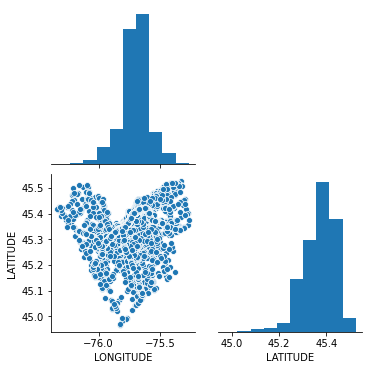

In [195]:
# Compare Long and Lat
sns.pairplot(data=collision[['LONGITUDE', 'LATITUDE']], corner=True);

We clearly get a scatter plot the shape of Ottawa. [Insert opendata image here] There are slight differences between default groupings of X and Long, and Y and Lat results based on slight differences of distributions. Overall, we see that more collisions occur in the middle of the city and decrease moving out of the downtown. Or could we say that there are just as many collisions within a certain radius of the city/downtown versus what is outside of the city?

For the rest of the values, I'll have to categorize the data and compare.

For example, to compare Road Surface Condition with collision X,Y, I will have to chaange the Road Surface Condition for Clear or Snow to a dummy variable then plot against location.

can I use a box plot for road condition and 


Can use knn-classification


Questions:
- is there a way to make a map where we can indicate the location and then assign the dot a colour on the map?
- can I identify likely regions for collisions in the cities then further investigate if there are conditions driving more collisions in that region (weather, road, lights


In [196]:
collision['road_cond_num'] = collision['Road_Surface_Condition'].replace({
    '01 - Dry':0,
    '02 - Wet':1,
    '03 - Loose snow':2,
    '04 - Slush':3,
    '05 - Packed snow':4,
    '06 - Ice':5,
    '07 - Mud':6,
    '08 - Loose sand or gravel':7,
    '09 - Spilled liquid':8,
    '00 - Unknown':9,
    '99 - Other':10,
})

collision['road_cond_num'].head(10)


0    3
1    0
2    0
3    3
4    4
5    0
6    3
7    0
8    0
9    2
Name: road_cond_num, dtype: int64

In [197]:
collision['Road_Surface_Condition'].value_counts()

01 - Dry                     10711
02 - Wet                      2788
03 - Loose snow                997
06 - Ice                       719
05 - Packed snow               580
04 - Slush                     577
08 - Loose sand or gravel       12
00 - Unknown                     9
99 - Other                       3
09 - Spilled liquid              2
07 - Mud                         1
Name: Road_Surface_Condition, dtype: int64

In [198]:
collision['road_cond_num'].value_counts()

0     10711
1      2788
2       997
5       719
4       580
3       577
7        12
9         9
10        3
8         2
6         1
Name: road_cond_num, dtype: int64

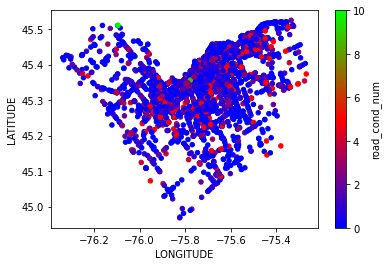

In [199]:
collision.plot(kind='scatter', x='LONGITUDE', y='LATITUDE', c='road_cond_num', colormap='brg', sharex=False);

The types of road conditions can be reduced to the top 6 most common road conditions, dropping the rows in collision df that include the following low occurance conditions:

- 08 - Loose sand or gravel       12
- 00 - Unknown                     9
- 99 - Other                       3
- 09 - Spilled liquid              2
- 07 - Mud                         1

In [200]:
# Drop rows with low occurance road surface conditions
collision = collision.drop(collision[(collision['road_cond_num'] == 6) | (collision['road_cond_num'] == 7) | (collision['road_cond_num'] == 8) | (collision['road_cond_num'] == 9) | (collision['road_cond_num'] == 10)].index) 
collision.road_cond_num.value_counts()

0    10711
1     2788
2      997
5      719
4      580
3      577
Name: road_cond_num, dtype: int64

Retry color map with new road conditions

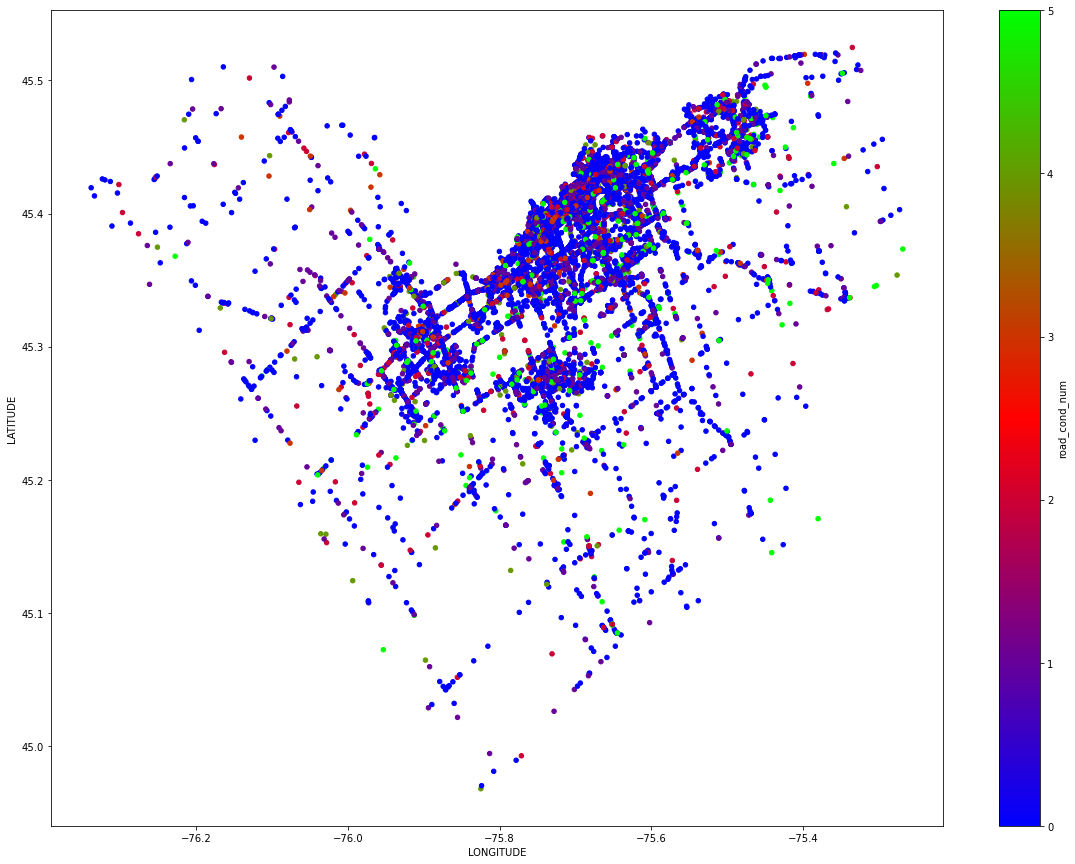

In [201]:
collision.plot(kind='scatter', x='LONGITUDE', y='LATITUDE', c='road_cond_num', colormap='brg', figsize=(20, 15), sharex=False);

For reference:

- 01 - Dry                     10711 - Blue
- 02 - Wet                      2788 - Purple
- 03 - Loose snow                997 - Red
- 04 - Slush                     577 - Orange(ish)
- 05 - Packed snow               580 - Dark Green(ish)
- 06 - Ice                       719 - Bright Green

Questions:
- Are there any patterns of most common areas of collisions with non-dry conditions.
    

In [202]:
collision_notdry = collision.drop(collision[(collision['road_cond_num'] == 0)].index) 
collision_notdry.road_cond_num.value_counts()

1    2788
2     997
5     719
4     580
3     577
Name: road_cond_num, dtype: int64

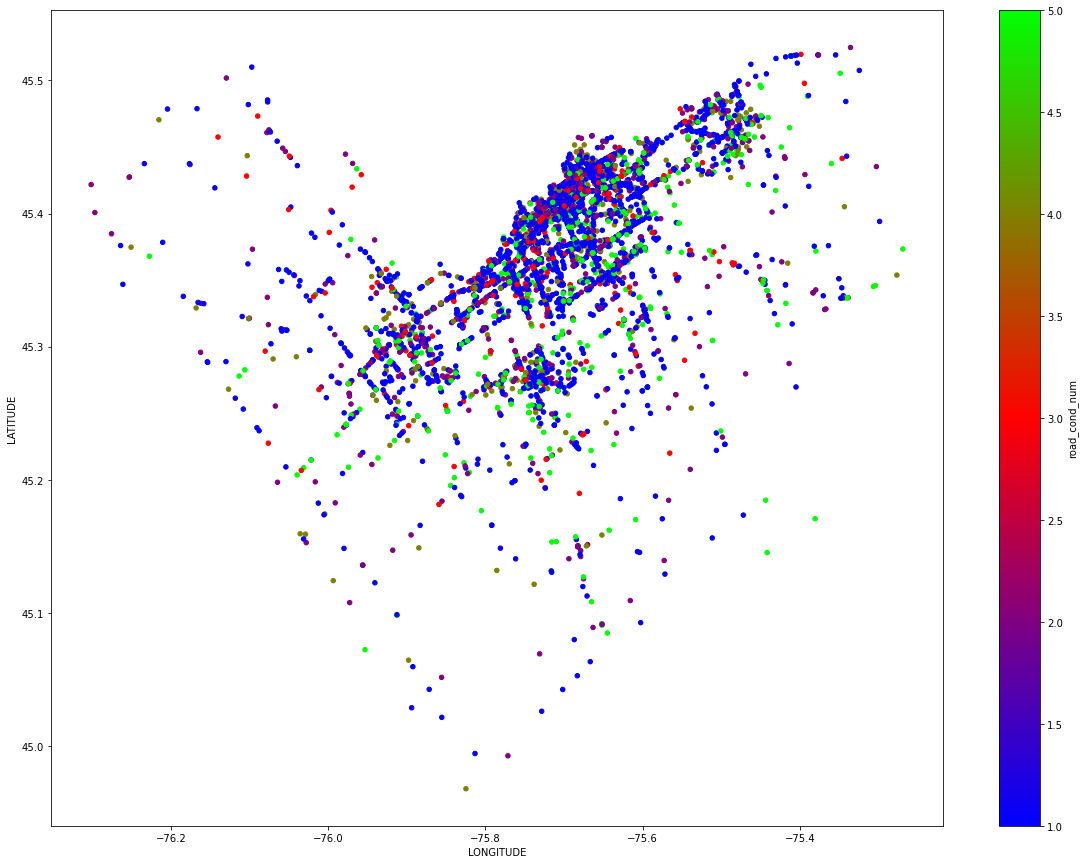

In [203]:
# Same scatter plot with no dry condition
collision_notdry.plot(kind='scatter', x='LONGITUDE', y='LATITUDE', c='road_cond_num', colormap='brg', figsize=(20, 15), sharex=False);

For reference:

- 02 - Wet                      2788 - Blue
- 03 - Loose snow                997 - Purple
- 04 - Slush                     577 - Red 
- 05 - Packed snow               580 - Orange Green(ish) 
- 06 - Ice                       719 - Bright Green

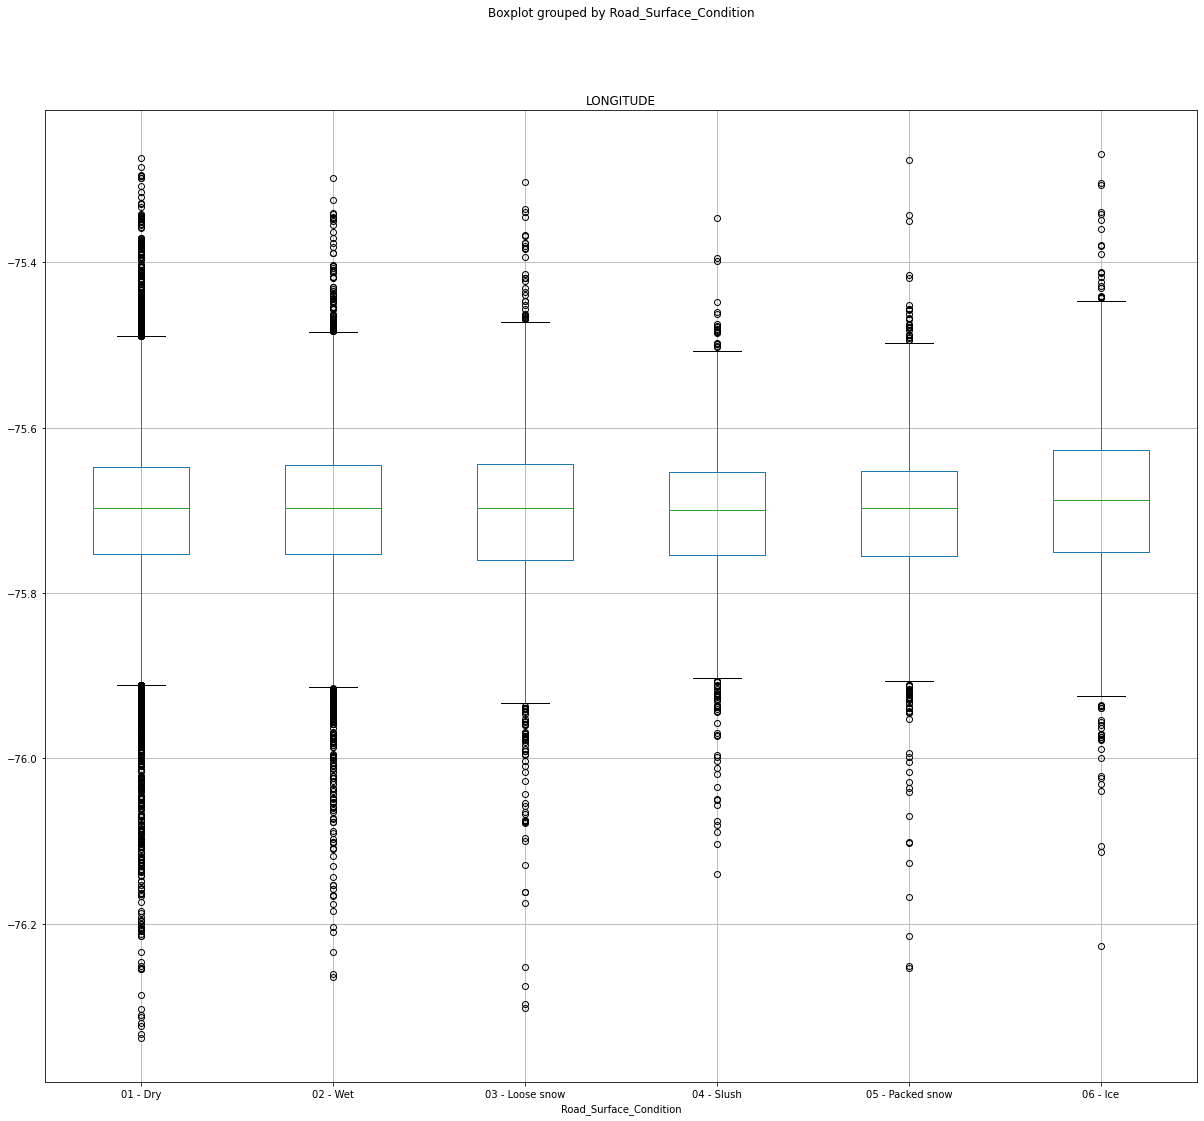

In [204]:
collision.boxplot(
    column=['LONGITUDE'],
    by='Road_Surface_Condition',
    figsize=(20,18)
);

Boxplots are not that useful here since we can already visualize that most accidents happen in the city core.

### Step Three: Clearly identify shortcomings, assumptions, and next steps.

#### Shortcomings
1. Scope may be too big for one city. Maybe the 3 roads with the most amount of annual collisions could be observed deeper.
2. Not enough numerical data in this example, so lots of dummy variables and classifiers need to be used.

#### Assumptions
1. NaN = No condition required for traffic control type (05 - None)
2. The four Unknown conditions 
3. Removed low occurance road condition rows


#### Next Steps
1. Build a classification tree to predict collision severity based on time of day, season,condition, etc. maybe this can just be in the downtown region, outside downtown and all. 

2. Scatter year by location by collision type

In [205]:
collision.to_csv('2019_Ottawa_Collision_Data.csv', index = True)

## MODEL PREPARATION

How can we learn when it will be most likely to have more collisions.
- month
- time of day
- accident location type
- classification of accident type - Y
- impact type
- environment type - X
- light condition type - X
- road condition type - X
- traffic control type - X
- functioning or non-functioning traffic control
- lat long location


This could require unsupervised learning where there is no desired y-value specified.

We could determine if there are greater number of collisions during ac certain time frame.

OR could we relate all data to determine conditions that would result in the following conclusions:

03 - P.D. only           13657 (property damage)
02 - Non-fatal injury     2691
01 - Fatal injury           24

Limitations to this model is that on any given day we do not know how many drivers were on the road to give an estimate on how many of those are collisions. 

This model will only provide information that IF there was a collision, what is the likelyhood of the collision to be fatal to someone involved and what are the possible conditions driving that conclusion. 

Let's use ONEHOTENCODER on the following items:
- classification of accident type - Y
- environment type - X
- light condition type - X
- road condition type - X
- traffic control - X